# Experimentation with Dimensionality Reduction

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
pd.options.display.max_columns = 75
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.formula.api as smf
%matplotlib inline

## Quick PCA
Quick graph of PCA as proof of concept that ideology can be inferred from campaign contributions via dimensionality reduction.

In [3]:
df_16 = pd.read_csv('preprocessed/campaign_finance/pac_direct_2016.csv', encoding='latin1')

In [4]:
subset = ['PACID','CID']
pac_int = df_16.drop_duplicates(subset=subset)[subset]
pac_int = pd.pivot(index=pac_int.CID, columns=pac_int.PACID, values=pd.Series([1]* len(pac_int)))
pac_int.fillna(0, inplace=True)

In [5]:
pac_int.head()

PACID,C00000059,C00000422,C00000547,C00000638,C00000729,C00000885,C00000901,C00000935,C00000984,C00001016,C00001198,C00001214,C00001388,C00001636,C00001727,C00001743,C00002089,C00002238,C00002261,C00002469,C00002600,C00002766,C00002790,C00002840,C00002881,C00002907,C00002972,C00003160,C00003194,C00003210,C00003251,C00003418,C00003558,C00003590,C00003632,C00003764,C00003806,...,C00614354,C00614552,C00614826,C00615096,C00615203,C00615294,C00615492,C00615690,C00615799,C00617027,C00617803,C00618033,C00619361,C00619528,C00619601,C00620088,C00620948,C00621011,C00621086,C00621276,C00621466,C00621631,C00621649,C00621987,C00622118,C00622654,C00623173,C00623405,C00624148,C00624171,C00624445,C00624502,C00625111,C00625145,C00625160,C00625988,C00627166
CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N00000036,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N00000078,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N00000153,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N00000179,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N00000267,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
pca = PCA(n_components=2)
pac_int_pca = pca.fit_transform(pac_int)
pac_int_pca = pd.DataFrame(pac_int_pca, columns=['pca_x','pca_y'], index=pac_int.index)
df_graph = pd.concat([df_16.drop_duplicates(subset=['CID'])[['CID', 'Party']].set_index('CID'), pac_int_pca], axis = 1)

In [8]:
c1 = df_graph.Party == 'D'
c2 = df_graph.Party == 'R'
df_graph = df_graph[c1 | c2]

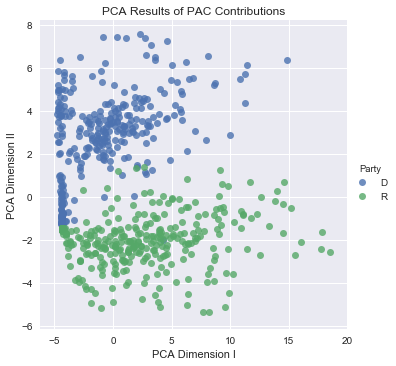

In [12]:
ax = seaborn.lmplot(data=df_graph, x = 'pca_x', y = 'pca_y', hue = 'Party', fit_reg=False)
ax.set(title = 'PCA Results of PAC Contributions', 
       xlabel='PCA Dimension I', 
       ylabel = 'PCA Dimension II', )
ax.savefig("pca.jpg")

Nice results, there are two clear groups based on candidate party.

## PPMI and SVD
Try an approach nearly identical to creating word embeddings in NLP. We want to:
1. Create a co-occurence matrix between candidates
2. Get Positive Pointwise Mutual Information (PPMI) 
3. Reduce by SVD
4. Create matrix of cosine similarities between candidates

In [128]:
def co_matrix(df, industry = None, total_contributions = False):
    """Create Co-occurrence matrix between candidates.
        Use PAC contibutions in common for election cycle(s) in df
        
    Args:
        df: Dataframe of PAC contributions
        industry: Filter PACs to only include certain industries. Optional.
        Total_contributions. If True, cells are populated with sum of contributions in common.
            If false, just considers the number of PACs
        
    Returns:
        Candidate X candidate co-occurrence matrix
    """
    # placeholder for filtering df by pac industry
    if industry:
        pass
    
    
    if total_contributions:
        #df = df[df.Amount >= 0]
        df = df.groupby(['CID', 'PACID']).Amount.sum()
        df = pd.DataFrame(df).reset_index()
        df = pd.pivot(index=df.CID, columns=df.PACID, values=df.Amount)
        df.fillna(0, inplace=True)
    else:
        df.drop_duplicates(subset = ['CID', 'PACID'], inplace = True)
        df = pd.pivot(index=df.CID, columns=df.PACID, values=pd.Series([1]* len(df)))
        df.fillna(0, inplace = True)
    
    df = df.dot(df.T)
    return df

def SVD(C, d = 100, PPMI = True):
    """Tranform a counts matrix to PPMI.
    
    Args:
        C: Co-occurrence dataframe of counts C_ij.
            Returned from function co_matrix
        D: Number of SVD components
        PPMI: If True, applies Positive Pointwise Mutual Information
    
    Returns:
      Dataframe with PPMI value
    """
    if PPMI:
        Z = float(C.sum().sum())  # total counts
        # sum each column (along rows)
        Zc = np.array(C.sum(axis=0), dtype=np.float64).flatten()
        # sum each row (along columns)
        Zr = np.array(C.sum(axis=1), dtype=np.float64).flatten()

        ##
        # PMI equation
        pmi = np.log(C * Z / (Zr * Zc))

        # Truncate to positive only
        C = np.maximum(0, pmi)  # take positive only
    
    transformer = TruncatedSVD(n_components=d)
    Wv = pd.DataFrame(transformer.fit_transform(C), 
                      index=C.index, 
                      columns = ['SVD_' + str(x) for x in range(d)])
    return Wv


df = co_matrix(df_16)
df = SVD(df)
df_cs = pd.DataFrame(cosine_similarity(df), 
                     index=df.index, 
                     columns=df.index)

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: divide by zero encountered in log


In [129]:
df_cs.head()

CID,N00000036,N00000078,N00000153,N00000179,N00000267,N00000515,N00000575,N00000615,N00000684,N00000743,N00000751,N00000781,N00000851,N00000898,N00000939,N00001003,N00001024,N00001093,N00001102,N00001127,N00001171,N00001193,N00001285,N00001311,N00001373,N00001489,N00001619,N00001692,N00001758,N00001811,N00001813,N00001821,N00001971,N00002147,N00002221,N00002260,N00002299,...,N00039658,N00039661,N00039664,N00039668,N00039682,N00039713,N00039733,N00039777,N00039786,N00039799,N00039835,N00039838,N00039861,N00039863,N00039931,N00039938,N00039951,N00039953,N00039985,N00039988,N00039997,N00040007,N00040012,N00040014,N00040015,N00040016,N00040028,N00040045,N00040051,N00040131,N00040133,N00040144,N00040167,N00040210,N00040259,N00040293,N00040337
CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N00000036,1.000000,0.721173,0.642864,0.765499,0.727093,0.664407,0.672259,0.785292,0.184070,0.129910,0.731693,0.718183,0.586486,0.355790,0.806768,0.730913,0.748275,0.696998,0.763379,0.690470,0.423290,0.615597,0.075899,0.744044,0.738389,0.163749,0.695456,0.690257,0.092670,0.061725,0.764119,0.716102,0.735650,0.752211,0.126990,0.690372,0.059180,...,0.651424,0.476837,0.274076,0.188751,0.634949,0.253729,-0.007657,0.090918,-1.274338e-06,-0.005543,0.068270,-0.002163,0.016355,0.431001,0.001264,0.265473,0.625872,-0.003147,0.013468,-0.053821,0.085441,0.023389,0.026581,-1.274338e-06,0.274076,-0.012315,0.017794,0.398427,0.618770,0.180416,0.710497,-0.001431,0.005398,0.474353,0.164705,0.005815,-1.274338e-06
N00000078,0.721173,1.000000,0.765493,0.829042,0.818786,0.793003,0.830666,0.868516,0.281108,0.231638,0.809538,0.816238,0.690072,0.448557,0.843511,0.802462,0.817901,0.689108,0.859943,0.811443,0.591592,0.755527,0.182061,0.886806,0.825340,0.212236,0.780634,0.816044,0.166380,0.129942,0.849598,0.835723,0.820163,0.882368,0.178701,0.820491,0.133711,...,0.413117,0.534024,0.307227,0.379518,0.620645,0.182859,0.000075,0.117429,1.809601e-06,0.011232,-0.000838,0.008287,-0.006461,0.473203,-0.000717,0.089326,0.717085,-0.000328,0.013963,-0.004585,0.344907,0.038032,-0.005119,1.809601e-06,0.307227,-0.010273,-0.004907,0.493340,0.671712,0.177527,0.735903,-0.000763,0.003912,0.532954,0.085438,0.001854,1.809601e-06
N00000153,0.642864,0.765493,1.000000,0.804727,0.859484,0.740951,0.827770,0.800723,0.287436,0.273150,0.760273,0.792784,0.636860,0.458737,0.760672,0.762969,0.725057,0.684659,0.786942,0.833181,0.551657,0.780691,0.323315,0.744368,0.810253,0.251403,0.663750,0.654520,0.247714,0.263889,0.753642,0.833963,0.732862,0.744432,0.271876,0.791522,0.149634,...,0.353368,0.614075,0.135015,0.078946,0.652403,0.148004,-0.007083,0.179449,5.412480e-06,0.012432,0.104776,0.006127,-0.024259,0.452229,0.002085,0.044071,0.657303,0.002324,0.014888,0.007543,0.000361,0.075245,0.001957,5.412480e-06,0.135015,-0.010390,-0.033113,0.326592,0.701400,0.062743,0.622946,-0.001947,0.009380,0.611706,0.068599,-0.001683,5.412480e-06
N00000179,0.765499,0.829042,0.804727,1.000000,0.902451,0.812628,0.840366,0.887260,0.268179,0.174493,0.848454,0.839288,0.741184,0.458742,0.862565,0.849010,0.795002,0.643091,0.891714,0.788934,0.518679,0.769315,0.124510,0.835626,0.906327,0.143586,0.809985,0.751464,0.088306,0.101269,0.869686,0.854555,0.880044,0.811492,0.121451,0.890208,0.097867,...,0.413872,0.562417,0.315356,0.110204,0.712860,0.285128,0.001828,0.182166,-7.613727e-07,0.000441,0.002351,-0.001735,0.011458,0.485082,-0.000222,0.094455,0.781389,-0.006732,0.021280,-0.016166,-0.000125,0.032676,-0.003545,-7.613727e-07,0.315356,-0.000932,0.008840,0.447598,0.724984,0.062485,0.764372,-0.000655,0.008053,0.560176,0.089422,0.004375,-7.613727e-07
N00000267,0.727093,0.818786,0.859484,0.902451,1.000000,0.826058,0.884055,0.850108,0.208475,0.214528,0.824852,0.800444,0.698530,0.477465,0.839155,0.860589,0.784583,0.641496,0.856903,0.769769,0.534677,0.778904,0.166607,0.789736,0.856068,0.160582,0.755369,0.746512,0.120144,0.150373,0.849195,0.820995,0.829181,0.773152,0.135474,0.870656,0.119574,...,0.390125,0.619463,0.36

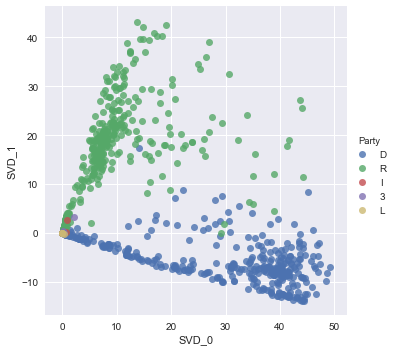

In [122]:
df_graph = pd.concat([df_16.drop_duplicates(subset=['CID'])[['CID', 'Party']].set_index('CID'), df], axis = 1)
seaborn.lmplot(data=df_graph, x = 'SVD_0', y = 'SVD_1', hue = 'Party', fit_reg=False)

### Proof of Concept with Aggregate Vote Data

In [131]:
# data pulled from Propublica Congress API
df_members = pd.read_csv('preprocessed/members_house.csv', encoding='latin1')
df_comparisons = pd.read_csv('preprocessed/comp_house_1.csv')

In [142]:
df_comparisons.columns

Index(['agree_percent', 'chamber', 'common_votes', 'congress',
       'disagree_percent', 'disagree_votes', 'first_member_api_uri',
       'first_member_id', 'second_member_api_uri', 'second_member_id'],
      dtype='object')

In [ ]:
df_

In [176]:
# get cosign similarity of current House of Representatives
df_16_house = df_16[df_16.CID.isin(list(df_members.crp_id))]
df_16_house = co_matrix(df_16_house)
df_16_house = SVD(df_16_house)
df_16_house = pd.DataFrame(cosine_similarity(df_16_house), 
                     index=df_16_house.index, 
                     columns=df_16_house.index)
df_16_house = pd.DataFrame(df_16_house.stack())
df_16_house.index.names = ['first_member_cid', 'second_member_cid']
df_16_house.reset_index(inplace=True)
df_16_house.rename(columns = {0: 'cosign_similarity'}, inplace=True)

# merge with vote comparison records
df_full = pd.merge(df_16_house, df_members, how = 'left', right_on = 'crp_id', left_on='first_member_cid')
df_full = pd.merge(df_full, df_members, 
                   how = 'left', right_on = 'crp_id', 
                   left_on='second_member_cid', suffixes = ['_first', '_second'])
df_full = pd.merge(df_comparisons, df_full, how = 'left',
                   right_on=['id_first', 'id_second'], 
                   left_on=['first_member_id', 'second_member_id'])
df_full.dropna(subset=['cosign_similarity'], inplace=True)
df_full['same_party'] = df_full.party_first == df_full.party_second

C:\Users\Steve\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: divide by zero encountered in log


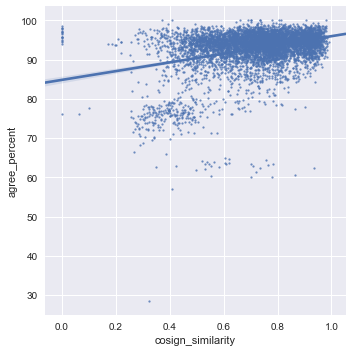

In [189]:
c1 = (df_full.party_first == 'R')
c2 = (df_full.party_second == 'R')
seaborn.lmplot(data=df_full[(c1 & c2)], x = 'cosign_similarity', y = 'agree_percent',scatter_kws={"s": 5})

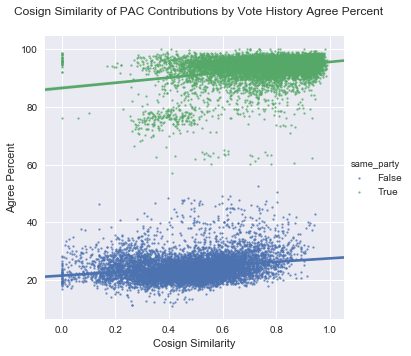

In [212]:

g =seaborn.lmplot(data=df_full, x = 'cosign_similarity', 
               y = 'agree_percent',
               hue = 'same_party', 
               scatter_kws={"s": 5})
g.set_ylabels('Agree Percent')
g.set_xlabels('Cosign Similarity')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Cosign Similarity of PAC Contributions by Vote History Agree Percent')

In [203]:
results = smf.ols('agree_percent ~ cosign_similarity + same_party', data = df_full).fit()

In [213]:
results = smf.ols('agree_percent ~ cosign_similarity + same_party + same_party * cosign_similarity', data = df_full).fit()

In [201]:
results = smf.ols('agree_percent ~ same_party', data = df_full).fit()

In [214]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          agree_percent   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 3.601e+05
Date:                Fri, 27 Oct 2017   Prob (F-statistic):               0.00
Time:                        02:31:23   Log-Likelihood:                -50108.
No. Observations:               17328   AIC:                         1.002e+05
Df Residuals:                   17324   BIC:                         1.003e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


In [184]:
df_full.columns

Index(['agree_percent', 'chamber', 'common_votes', 'congress',
       'disagree_percent', 'disagree_votes', 'first_member_api_uri',
       'first_member_id', 'second_member_api_uri', 'second_member_id',
       'first_member_cid', 'second_member_cid', 'cosign_similarity',
       'api_uri_first', 'at_large_first', 'contact_form_first', 'crp_id_first',
       'cspan_id_first', 'date_of_birth_first', 'district_first',
       'dw_nominate_first', 'facebook_account_first', 'fax_first',
       'fec_candidate_id_first', 'first_name_first', 'geoid_first',
       'google_entity_id_first', 'govtrack_id_first', 'icpsr_id_first',
       'id_first', 'ideal_point_first', 'in_office_first', 'last_name_first',
       'leadership_role_first', 'middle_name_first', 'missed_votes_first',
       'missed_votes_pct_first', 'next_election_first', 'ocd_id_first',
       'office_first', 'party_first', 'phone_first', 'rss_url_first',
       'seniority_first', 'short_title_first', 'state_first', 'title_first',
   

In [178]:
df_full.shape

(18810, 95)

In [175]:
df_comparisons.shape

(18810, 10)

In [167]:
df_full.shape

(190096, 44)

In [169]:
df_full.shape

(190096, 85)

In [162]:
df_full.head()

,api_uri,at_large,contact_form,crp_id,cspan_id,date_of_birth,district,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,geoid,google_entity_id,govtrack_id,icpsr_id,id,ideal_point,in_office,last_name,leadership_role,middle_name,missed_votes,missed_votes_pct,next_election,ocd_id,office,party,phone,rss_url,seniority,short_title,state,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account,first_member_cid,second_member_cid,cosign_similarity
0,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN,N00036633,N00000078,0.549930
1,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN,N00036633,N00000153,0.619462
2,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN,N00036633,N00000179,0.524191
3,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN,N00036633,N00000267,0.485342
4,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN,N00036633,N00000515,0.519362


In [159]:
df_comparisons.head()

,agree_percent,chamber,common_votes,congress,disagree_percent,disagree_votes,first_member_api_uri,first_member_id,second_member_api_uri,second_member_id
0,21.91,House,566,115,78.09,442,https://api.propublica.org/congress/v1/members...,A000374,https://api.propublica.org/congress/v1/members...,A000370
1,94.84,House,543,115,5.16,28,https://api.propublica.org/congress/v1/members...,A000374,https://api.propublica.org/congress/v1/members...,A000055
2,23.89,House,561,115,76.11,427,https://api.propublica.org/congress/v1/members...,A000374,https://api.propublica.org/congress/v1/members...,A000371
3,97.52,House,565,115,2.48,14,https://api.propublica.org/congress/v1/members...,A000374,https://api.propublica.org/congress/v1/members...,A000372
4,75.62,House,566,115,24.38,138,https://api.propublica.org/congress/v1/members...,A000374,https://api.propublica.org/congress/v1/members...,A000367


In [158]:
df_16_house.head()

,first_member_id,second_member_id,cosign_similarity
0,N00000078,N00000078,1.000000
1,N00000078,N00000153,0.883396
2,N00000078,N00000179,0.933667
3,N00000078,N00000267,0.933371
4,N00000078,N00000515,0.767678


In [135]:
df_comparisons.shape

(18810, 10)

In [132]:
df_members.head()

,api_uri,at_large,contact_form,crp_id,cspan_id,date_of_birth,district,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,geoid,google_entity_id,govtrack_id,icpsr_id,id,ideal_point,in_office,last_name,leadership_role,middle_name,missed_votes,missed_votes_pct,next_election,ocd_id,office,party,phone,rss_url,seniority,short_title,state,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,False,NaN,N00036633,76236,1954-09-16,5,0.493,CongressmanRalphAbraham,202-225-5639,H4LA05221,Ralph,2205,/m/012dwd7_,412630,21522.0,A000374,NaN,True,Abraham,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:la/cd:5,417 Cannon House Office Building,R,202-225-8490,https://abraham.house.gov/rss.xml,4,Rep.,LA,Representative,0.0,571.0,RepAbraham,https://abraham.house.gov/,96.13,155414.0,NaN
1,https://api.propublica.org/congress/v1/members...,False,NaN,N00035451,76386,1946-05-27,12,-0.462,CongresswomanAdams,202-225-1512,H4NC12100,Alma,3712,/m/02b45d,412607,21545.0,A000370,NaN,True,Adams,NaN,NaN,1.0,0.18,2018.0,ocd-division/country:us/state:nc/cd:12,222 Cannon House Office Building,D,202-225-1510,https://adams.house.gov/rss.xml,6,Rep.,NC,Representative,0.0,571.0,RepAdams,https://adams.house.gov/,96.84,5935.0,NaN
2,https://api.propublica.org/congress/v1/members...,False,NaN,N00003028,45516,1965-07-22,4,0.360,RobertAderholt,202-225-5587,H6AL04098,Robert,104,/m/024p03,400004,29701.0,A000055,NaN,True,Aderholt,NaN,B.,24.0,4.20,2018.0,ocd-division/country:us/state:al/cd:4,235 Cannon House Office Building,R,202-225-4876,https://aderholt.house.gov/rss.xml,22,Rep.,AL,Representative,0.0,571.0,Robert_Aderholt,https://aderholt.house.gov/,95.25,441.0,RobertAderholt
3,https://api.propublica.org/congress/v1/members...,False,NaN,N00033997,79994,1979-06-19,31,-0.273,reppeteaguilar,202-226-6962,H2CA31125,Pete,631,/m/0jwv0xf,412615,21506.0,A000371,NaN,True,Aguilar,NaN,NaN,6.0,1.05,2018.0,ocd-division/country:us/state:ca/cd:31,1223 Longworth House Office Building,D,202-225-3201,https://aguilar.house.gov/rss.xml,4,Rep.,CA,Representative,0.0,571.0,reppeteaguilar,https://aguilar.house.gov/,93.81,70114.0,NaN
4,https://api.propublica.org/congress/v1/members...,False,NaN,N00033720,62545,1951-11-07,12,0.614,CongressmanRickAllen,202-225-3377,H2GA12121,Rick,1312,/m/0127y9dk,412625,21516.0,A000372,NaN,True,Allen,NaN,NaN,2.0,0.35,2018.0,ocd-division/country:us/state:ga/cd:12,426 Cannon House Office Building,R,202-225-2823,NaN,4,Rep.,GA,Representative,0.0,571.0,reprickallen,https://allen.house.gov/,97.89,136062.0,NaN


In [119]:
df.head()


,SVD_0,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25,SVD_26,SVD_27,SVD_28,SVD_29,SVD_30,SVD_31,SVD_32,SVD_33,SVD_34,SVD_35,SVD_36,...,SVD_63,SVD_64,SVD_65,SVD_66,SVD_67,SVD_68,SVD_69,SVD_70,SVD_71,SVD_72,SVD_73,SVD_74,SVD_75,SVD_76,SVD_77,SVD_78,SVD_79,SVD_80,SVD_81,SVD_82,SVD_83,SVD_84,SVD_85,SVD_86,SVD_87,SVD_88,SVD_89,SVD_90,SVD_91,SVD_92,SVD_93,SVD_94,SVD_95,SVD_96,SVD_97,SVD_98,SVD_99
CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N00000036,42.188772,-10.167645,3.307289,10.486643,10.168601,2.446375,13.128161,5.441120,-2.023133,-1.820582,-8.796652,-1.608975,-0.719928,-1.481852,0.504794,1.284729,-0.853213,1.924692,1.918272,2.231092,1.462890,-3.569684,2.182556,4.117801,5.816727,-1.246012,2.250378,0.789418,2.466850,0.719949,7.265440,0.216337,1.175329,2.733077,0.158602,0.479290,1.248105,...,6.022332,-1.146261,2.512559,0.436865,0.825199,-4.078724,0.920033,-2.581829,1.289799,-1.739084,-0.828337,3.133962,0.426739,0.709642,1.366729,1.385138,0.010034,1.573326,-1.680386,-2.319156,-2.729236,1.511268,0.013874,-1.352120,0.134551,-0.547482,1.359476,-0.420399,0.219173,0.875816,-0.054580,-0.800813,-1.785430,-2.953111,1.177773,-0.401910,0.685373
N00000078,40.539218,-5.138171,0.884235,-1.884027,-3.565536,4.772681,-2.634597,6.700459,2.977639,-3.884022,-5.957382,3.328834,-2.611392,5.027859,-0.973518,1.100232,1.604550,2.732567,0.025821,0.723904,-4.363165,-0.609764,-0.584564,1.938772,-2.918078,-2.161610,2.852416,3.506788,-1.179431,-2.383156,2.485618,-1.243865,2.669824,0.095713,2.076330,0.094257,1.977890,...,0.708808,2.553327,1.325433,2.161363,0.054462,0.064753,1.033114,0.074162,0.097475,0.485354,-1.759842,-1.514453,-0.149889,0.032095,-1.358155,-1.188151,-0.671519,-1.841208,0.501069,0.643936,0.294263,-2.206877,0.001769,-1.096763,1.772650,-1.528405,-0.550827,0.709317,0.635468,1.567983,-1.108716,-0.233102,0.146117,0.871528,-1.969160,0.768548,0.648850
N00000153,30.903106,0.171493,-3.103805,-2.268059,-5.249102,4.012824,2.324978,-1.311055,1.024499,-3.319786,2.773134,-4.339178,-0.581769,0.748305,-2.340201,1.238200,5.340946,-0.630730,-0.944735,-2.903637,-0.284729,-0.788113,-0.694033,1.032013,3.434003,-1.520664,0.392687,2.990312,0.360326,-2.158685,-0.734381,2.666336,-3.051683,-3.934177,4.226738,-2.015246,-0.109069,...,2.295218,2.154105,0.474653,0.301668,-1.479361,-1.338266,-1.739599,0.300180,-0.031798,0.587901,0.161103,-0.430442,-1.813899,1.412092,1.273913,-0.391088,-0.385830,0.457058,1.634095,1.543679,-0.400736,-0.065522,0.005069,-0.719236,0.956338,-1.417469,0.544557,0.809262,-0.654237,0.344245,-0.780048,-0.710531,-1.488262,0.178379,-1.005373,1.026616,0.611990
N00000179,40.078429,-8.306998,0.065809,-2.354076,-4.505691,2.752826,-0.325739,3.109799,-1.425565,2.860061,2.494595,-1.713607,-0.211069,-1.506341,1.965272,-1.341898,-4.196508,0.546942,1.194597,0.610315,0.078209,-0.782910,-2.435793,2.356591,0.724449,1.261027,1.962573,4.506341,-1.761808,-1.455114,1.655307,1.284983,0.119830,0.576002,-0.401747,-1.273270,-0.661384,...,1.378749,-0.887197,-0.919855,0.465997,0.768350,1.806295,-0.001743,0.373175,1.395215,0.758269,-0.054665,-1.307967,-0.241193,0.057543,0.488379,-0.002863,0.255950,-0.814290,0.865514,0.396698,-1.276226,-2.025944,0.004582,0.229080,-0.966725,0.625198,0.074366,-0.337977,-0.136783,0.312538,-0.738421,-0.530108,0.400577,-0.304797,-0.019552,0.026646,-0.070359
N00000267,33.744130,-5.678604,-0.171642,-4.597753,-5.123648,2.653860,2.573415,0.537476,-0.893561,-0.181157,0.423303,-2.654099,-0.657125,-1.686428,-1.132043,-2.011343,-1.767499,-1.800223,-2.042943,-3.641633,-2.653895,1.245290,-1.005358,1.230596,-0.415005,0.300524,1.747169,5.405802,-3.068701,-1.669273,3.435409,1.722775,-1.602680,-0.052489,3.392934,-0.840239,-1.062046,...,0.353854,-0.627045,-0.321588,0.150529,0.694932,-2.411976,-0.750899,-0.532885,-1.619639,1.306072,0.792065,0.733966,0.564801,1.180965,1.884274,-0.143543,-1.214073,-1.317667,-0.68664

In [107]:
df.head()

CID,N00000036,N00000078,N00000153,N00000179,N00000267,N00000515,N00000575,N00000615,N00000684,N00000743,N00000751,N00000781,N00000851,N00000898,N00000939,N00001003,N00001024,N00001093,N00001102,N00001127,N00001171,N00001193,N00001285,N00001311,N00001373,N00001489,N00001619,N00001692,N00001758,N00001811,N00001813,N00001821,N00001971,N00002147,N00002221,N00002260,N00002299,...,N00039658,N00039661,N00039664,N00039668,N00039682,N00039713,N00039733,N00039777,N00039786,N00039799,N00039835,N00039838,N00039861,N00039863,N00039931,N00039938,N00039951,N00039953,N00039985,N00039988,N00039997,N00040007,N00040012,N00040014,N00040015,N00040016,N00040028,N00040045,N00040051,N00040131,N00040133,N00040144,N00040167,N00040210,N00040259,N00040293,N00040337
CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N00000036,2.805274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200514,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.412173,0.000000,0.143774,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.185437,0.000000,0.0,0.763310,0.697352,0.0,0.00000,1.206796,0.0,0.000000,0.082661,0.0,0.000000,0.000000,...,3.808933,5.058259,5.640368,8.505139,3.536450,5.658468,0.0,0.000000,0.0,0.0,3.631963,0.0,0.0,5.135220,0.0,9.92953,2.244175,0.0,0.0,0.0,0.000000,1.074150,0.0,0.0,5.640368,0.0,0.0,5.091975,3.871259,6.634323,1.441601,0.0,0.0,5.126759,0.0,0.0,0.0
N00000078,1.418979,1.313082,0.000000,0.565090,0.699479,0.000000,0.000000,0.449410,0.000000,0.945501,0.020359,0.000000,0.0,0.000000,0.773963,0.325305,0.690317,0.0,0.705974,0.000000,0.508500,0.599448,0.000000,0.436751,0.097192,0.0,1.168775,0.994604,0.0,0.00000,1.574521,0.0,0.447800,0.488126,0.0,0.293236,1.047282,...,2.595910,5.058259,5.640368,8.505139,3.536450,0.000000,0.0,0.466089,0.0,0.0,0.000000,0.0,0.0,4.729755,0.0,0.00000,2.061853,0.0,0.0,0.0,9.643328,0.381003,0.0,0.0,5.640368,0.0,0.0,4.398828,3.465794,5.941176,1.287450,0.0,0.0,5.126759,0.0,0.0,0.0
N00000153,0.865594,0.552276,1.042919,0.812926,0.853630,0.207051,0.457261,0.449410,0.432559,0.930463,0.392763,0.078381,0.0,0.445386,0.773963,0.650728,0.672618,0.0,0.618962,0.175922,0.712099,0.685215,0.259829,0.420751,0.393923,0.0,0.968105,0.806551,0.0,0.22905,1.089013,0.0,0.372576,0.642277,0.0,0.698701,1.047282,...,1.989774,5.058259,0.000000,0.000000,3.130985,0.000000,0.0,1.025705,0.0,0.0,3.631963,0.0,0.0,4.036608,0.0,0.00000,1.145563,0.0,0.0,0.0,0.000000,1.767297,0.0,0.0,0.000000,0.0,0.0,0.000000,2.772647,0.000000,0.594303,0.0,0.0,5.126759,0.0,0.0,0.0
N00000179,1.226607,0.105989,0.000000,1.449632,0.501653,0.000000,0.000000,0.515008,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.619812,0.344354,0.360838,0.0,0.341330,0.000000,0.000000,0.178945,0.000000,0.354059,0.200732,0.0,1.106255,0.994604,0.0,0.00000,1.344946,0.0,0.291231,0.264983,0.0,0.440872,1.000762,...,2.395239,5.058259,5.640368,0.000000,3.536450,5.658468,0.0,0.689233,0.0,0.0,0.000000,0.0,0.0,4.036608,0.0,0.00000,2.244175,0.0,0.0,0.0,0.000000,1.479615,0.0,0.0,5.640368,0.0,0.0,4.398828,3.871259,0.000000,1.367493,0.0,0.0,5.126759,0.0,0.0,0.0
N00000267,1.131297,0.303814,0.000000,0.565090,1.360050,0.000000,0.000000,0.303698,0.000000,0.429688,0.056291,0.000000,0.0,0.000000,0.718903,0.245263,0.360838,0.0,0.341330,0.000000,0.210007,0.326581,0.000000,0.122258,0.060150,0.0,0.891144,1.102817,0.0,0.00000,1.344946,0.0,0.145519,0.264983,0.0,0.380247,0.441146,...,1.807453,5.058259,5.640368,0.000000,2.843303,0.000000,0.0,0.000000,0.0,0.0,5.018258,0.0,0.0,4.729755,0.0,0.00000,2.244175,0.0,0.0,0.0,0.000000,0.381003,0.0,0.0,5.640368,0.0,0.0,4.398828,3.465794,0.000000,0.817447,0.0,0.0,5.126759,0.0,0.0,0.0


In [ ]:
pd.get_dummies(df.CID, df.PACID)

In [90]:
df.shape

(755, 755)

In [85]:
df.iloc[0,0]

4009252169.0

In [91]:
df.head()

CID,N00000036,N00000078,N00000153,N00000179,N00000267,N00000515,N00000575,N00000615,N00000684,N00000743,N00000751,N00000781,N00000851,N00000898,N00000939,N00001003,N00001024,N00001093,N00001102,N00001127,N00001171,N00001193,N00001285,N00001311,N00001373,N00001489,N00001619,N00001692,N00001758,N00001811,N00001813,N00001821,N00001971,N00002147,N00002221,N00002260,N00002299,...,N00039658,N00039661,N00039664,N00039668,N00039682,N00039713,N00039733,N00039777,N00039786,N00039799,N00039835,N00039838,N00039861,N00039863,N00039931,N00039938,N00039951,N00039953,N00039985,N00039988,N00039997,N00040007,N00040012,N00040014,N00040015,N00040016,N00040028,N00040045,N00040051,N00040131,N00040133,N00040144,N00040167,N00040210,N00040259,N00040293,N00040337
CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N00000036,160.0,40.0,23.0,33.0,30.0,35.0,27.0,46.0,6.0,5.0,41.0,42.0,38.0,17.0,39.0,25.0,33.0,78.0,25.0,40.0,14.0,21.0,13.0,49.0,33.0,18.0,22.0,26.0,16.0,5.0,27.0,48.0,34.0,40.0,16.0,22.0,6.0,...,37.0,1.0,1.0,1.0,6.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,6.0,2.0,28.0,0.0,0.0,1.0,0.0,0.0,0.0
N00000078,40.0,214.0,100.0,64.0,78.0,74.0,110.0,59.0,37.0,67.0,82.0,74.0,62.0,44.0,56.0,52.0,57.0,169.0,72.0,143.0,93.0,67.0,41.0,63.0,55.0,123.0,33.0,35.0,97.0,44.0,39.0,142.0,69.0,60.0,117.0,44.0,22.0,...,11.0,1.0,1.0,1.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,1.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0
N00000153,23.0,100.0,329.0,82.0,91.0,93.0,182.0,59.0,76.0,66.0,119.0,137.0,76.0,80.0,56.0,72.0,56.0,255.0,66.0,210.0,114.0,73.0,105.0,62.0,74.0,209.0,27.0,29.0,178.0,79.0,24.0,224.0,64.0,70.0,237.0,66.0,22.0,...,6.0,1.0,0.0,0.0,4.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0
N00000179,33.0,64.0,82.0,155.0,64.0,64.0,72.0,63.0,37.0,13.0,72.0,69.0,62.0,38.0,48.0,53.0,41.0,103.0,50.0,88.0,42.0,44.0,45.0,58.0,61.0,59.0,31.0,35.0,68.0,30.0,31.0,91.0,59.0,48.0,83.0,51.0,21.0,...,9.0,1.0,1.0,0.0,6.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,26.0,0.0,0.0,1.0,0.0,0.0,0.0
N00000267,30.0,78.0,91.0,64.0,151.0,55.0,98.0,51.0,42.0,40.0,85.0,67.0,75.0,37.0,53.0,48.0,41.0,120.0,50.0,106.0,69.0,51.0,44.0,46.0,53.0,79.0,25.0,39.0,74.0,39.0,31.0,112.0,51.0,48.0,92.0,48.0,12.0,...,5.0,1.0,1.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0


In [88]:
df_16[df_16.CID == 'N00000036'].Amount.sum() ** 2

250875765625.0